# HighD dataset analysis

In [1]:
#TO BE RUN TWICE TO ACTIVATE THE INTERACTIVE PLOTS

import scipy.io
import numpy as np
from sklearn import manifold, datasets
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.mixture import GaussianMixture
from mpl_toolkits.mplot3d import Axes3D
import time
from matplotlib.pyplot import scatter
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots_adjust
import matplotlib
from tqdm import tqdm

%matplotlib notebook

(8671, 784)
(8671,)


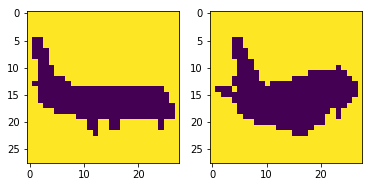

In [2]:
silhouette = scipy.io.loadmat('silhouette.mat')
data = silhouette['X']
labels = silhouette['Y'].transpose().ravel()

print(np.shape(data))
print(np.shape(labels))

fig = plt.figure(0)
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(np.transpose(np.reshape(data[500,:],(28,28))))
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(np.transpose(np.reshape(data[300,:],(28,28))))

In [3]:
# take only the first 10 classes

data_new = data[labels==1,:]

for label in range(2,11):
    data_new = np.concatenate((data_new, data[labels==label,:]), axis=0)
    
labels_new = labels[0:np.size(data_new,0)]

print(np.shape(data_new))
print(np.shape(labels_new))

(2906, 784)
(2906,)


In [ ]:
method = ['hessian','standard']
embed = manifold.LocallyLinearEmbedding(n_neighbors = 300 , n_components=3,
                                                             eigen_solver='dense',
                                                             method=method[0])
projected_hess = embed.fit_transform(data_new)
embed = manifold.LocallyLinearEmbedding(n_neighbors = 300 , n_components=3,
                                                             eigen_solver='dense',
                                                             method=method[1])
projected_std = embed.fit_transform(data_new)

In [ ]:
fig = plt.figure(figsize = plt.figaspect(0.5))
matplotlib.rcParams.update({'font.size': 10})

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.scatter(projected_hess[:,0], projected_hess[:,1],projected_hess[:,2], c=labels_new)
plt.title('HLLE',fontsize=20)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.scatter(projected_std[:,0], projected_std[:,1],projected_std[:,2], c=labels_new)
plt.title('LLE',fontsize=20)

In [ ]:
classifier = SGDClassifier(loss='log',max_iter=100, tol=1e-5)
start1 = time.time()
model = classifier.fit(data_new, labels_new)
stop1 = time.time()
score = model.score(data_new, labels_new)
print('Logistic Regression on the origninal space took {:0.2f} seconds to perform a train accuracy of {:0.2f}%' .format((stop1-start1), 100*score))

classifier = SGDClassifier(loss='log',max_iter=100, tol=1e-5)
start = time.time()
model = classifier.fit(projected_hess, labels_new)
stop = time.time()
time1 = stop-start
score1 = model.score(projected_hess, labels_new)

start = time.time()
model = classifier.fit(projected_std, labels_new)
stop = time.time()
time2 = stop-start
score2 = model.score(projected_std, labels_new)

print('With a 3D embedding using LLE and HLLE, the resulting classification accuracy on the embedded space are {:0.2f}% and {:0.2f}% respectively' .format(100*score2, 100*score1))
print('Moreover, the classifier took {:0.2f} and {:0.2f} seconds respectively' .format(time2, time1))


In [ ]:

# perform grid search on LLE only
n_components = [20,50,100,150,200]
neigh = [250,300,350,400]
method = ['standard']
scores_lleonly = np.zeros((len(neigh),len(n_components)))

for idxn,neighb in enumerate(tqdm(neigh)):
    for idxc,comp in enumerate(n_components):
        classifier = SGDClassifier(loss='log',max_iter=100, tol=1e-5)

        embed = manifold.LocallyLinearEmbedding(n_neighbors = neighb , n_components=comp,
                                                         eigen_solver='dense',
                                                         method=method[0])
        classifier = SGDClassifier(loss='log',max_iter=100, tol=1e-5)
        projected_std = embed.fit_transform(data_new)
        model = classifier.fit(projected_std, labels_new)
        scores_lleonly[idxn][idxc] = model.score(projected_std, labels_new)

In [ ]:
matplotlib.rcParams.update({'font.size': 14})
plt.imshow(scores_lleonly)

ax = plt.gca();
ax.set_xticks(np.arange(0, 5, 1));
ax.set_yticks(np.arange(0, 4, 1));
ax.set_xticklabels(n_components);
ax.set_yticklabels(neigh);

cbar = plt.colorbar()
cbar.set_label('Classification accuracy [%]')
plt.xlabel('Dimensionality of output space')
plt.ylabel('Number of neighbors')
plt.show()